In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
import torchvision

import PIL


In [114]:

def visualize_resnet_features(model, image):
    image = image.unsqueeze(0)
    outputs = []
    names = []
    i = 1
    for layer in model.resnet_layers[:4]:
        image = layer(image)
        outputs.append(image)
        names.append(f'layer {i}')
        i += 1
    for seq in model.resnet_layers[4:8]:
        for layer in seq:
            image = layer(image)
            outputs.append(image)
            names.append(f'layer {i}')
            i += 1
    # # print feature_maps
    # for feature_map in outputs:
    #     print(feature_map.shape)

    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    # for fm in processed:
    #     print(fm.shape)

    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)
    # plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

torch.float32

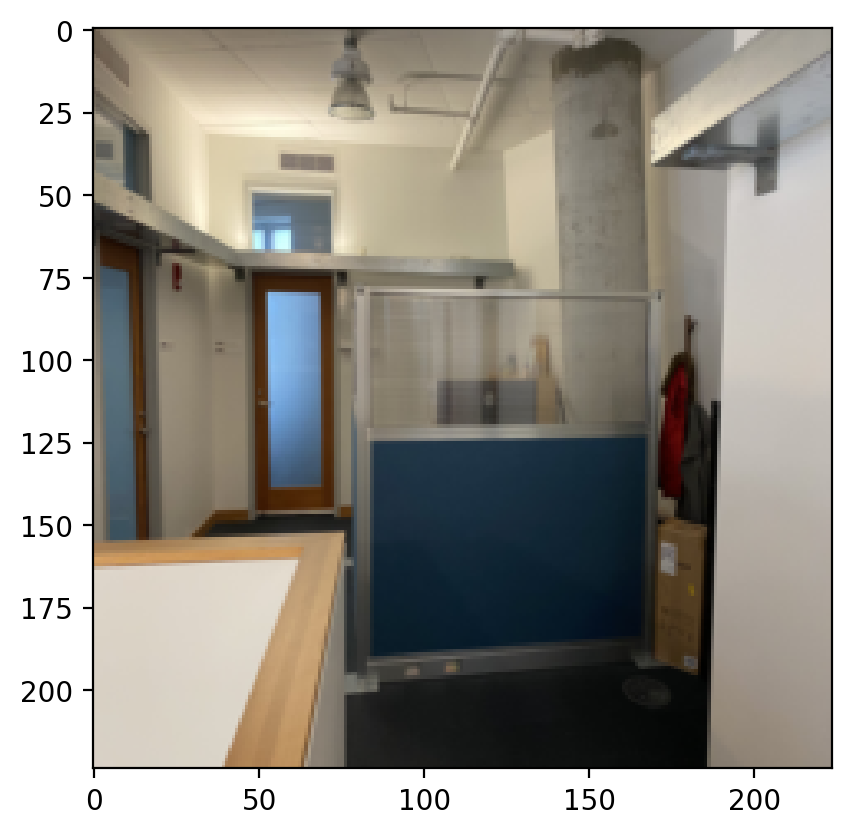

In [117]:
image = val[5][0]
plt.imshow(image.permute(1, 2, 0))
image.dtype

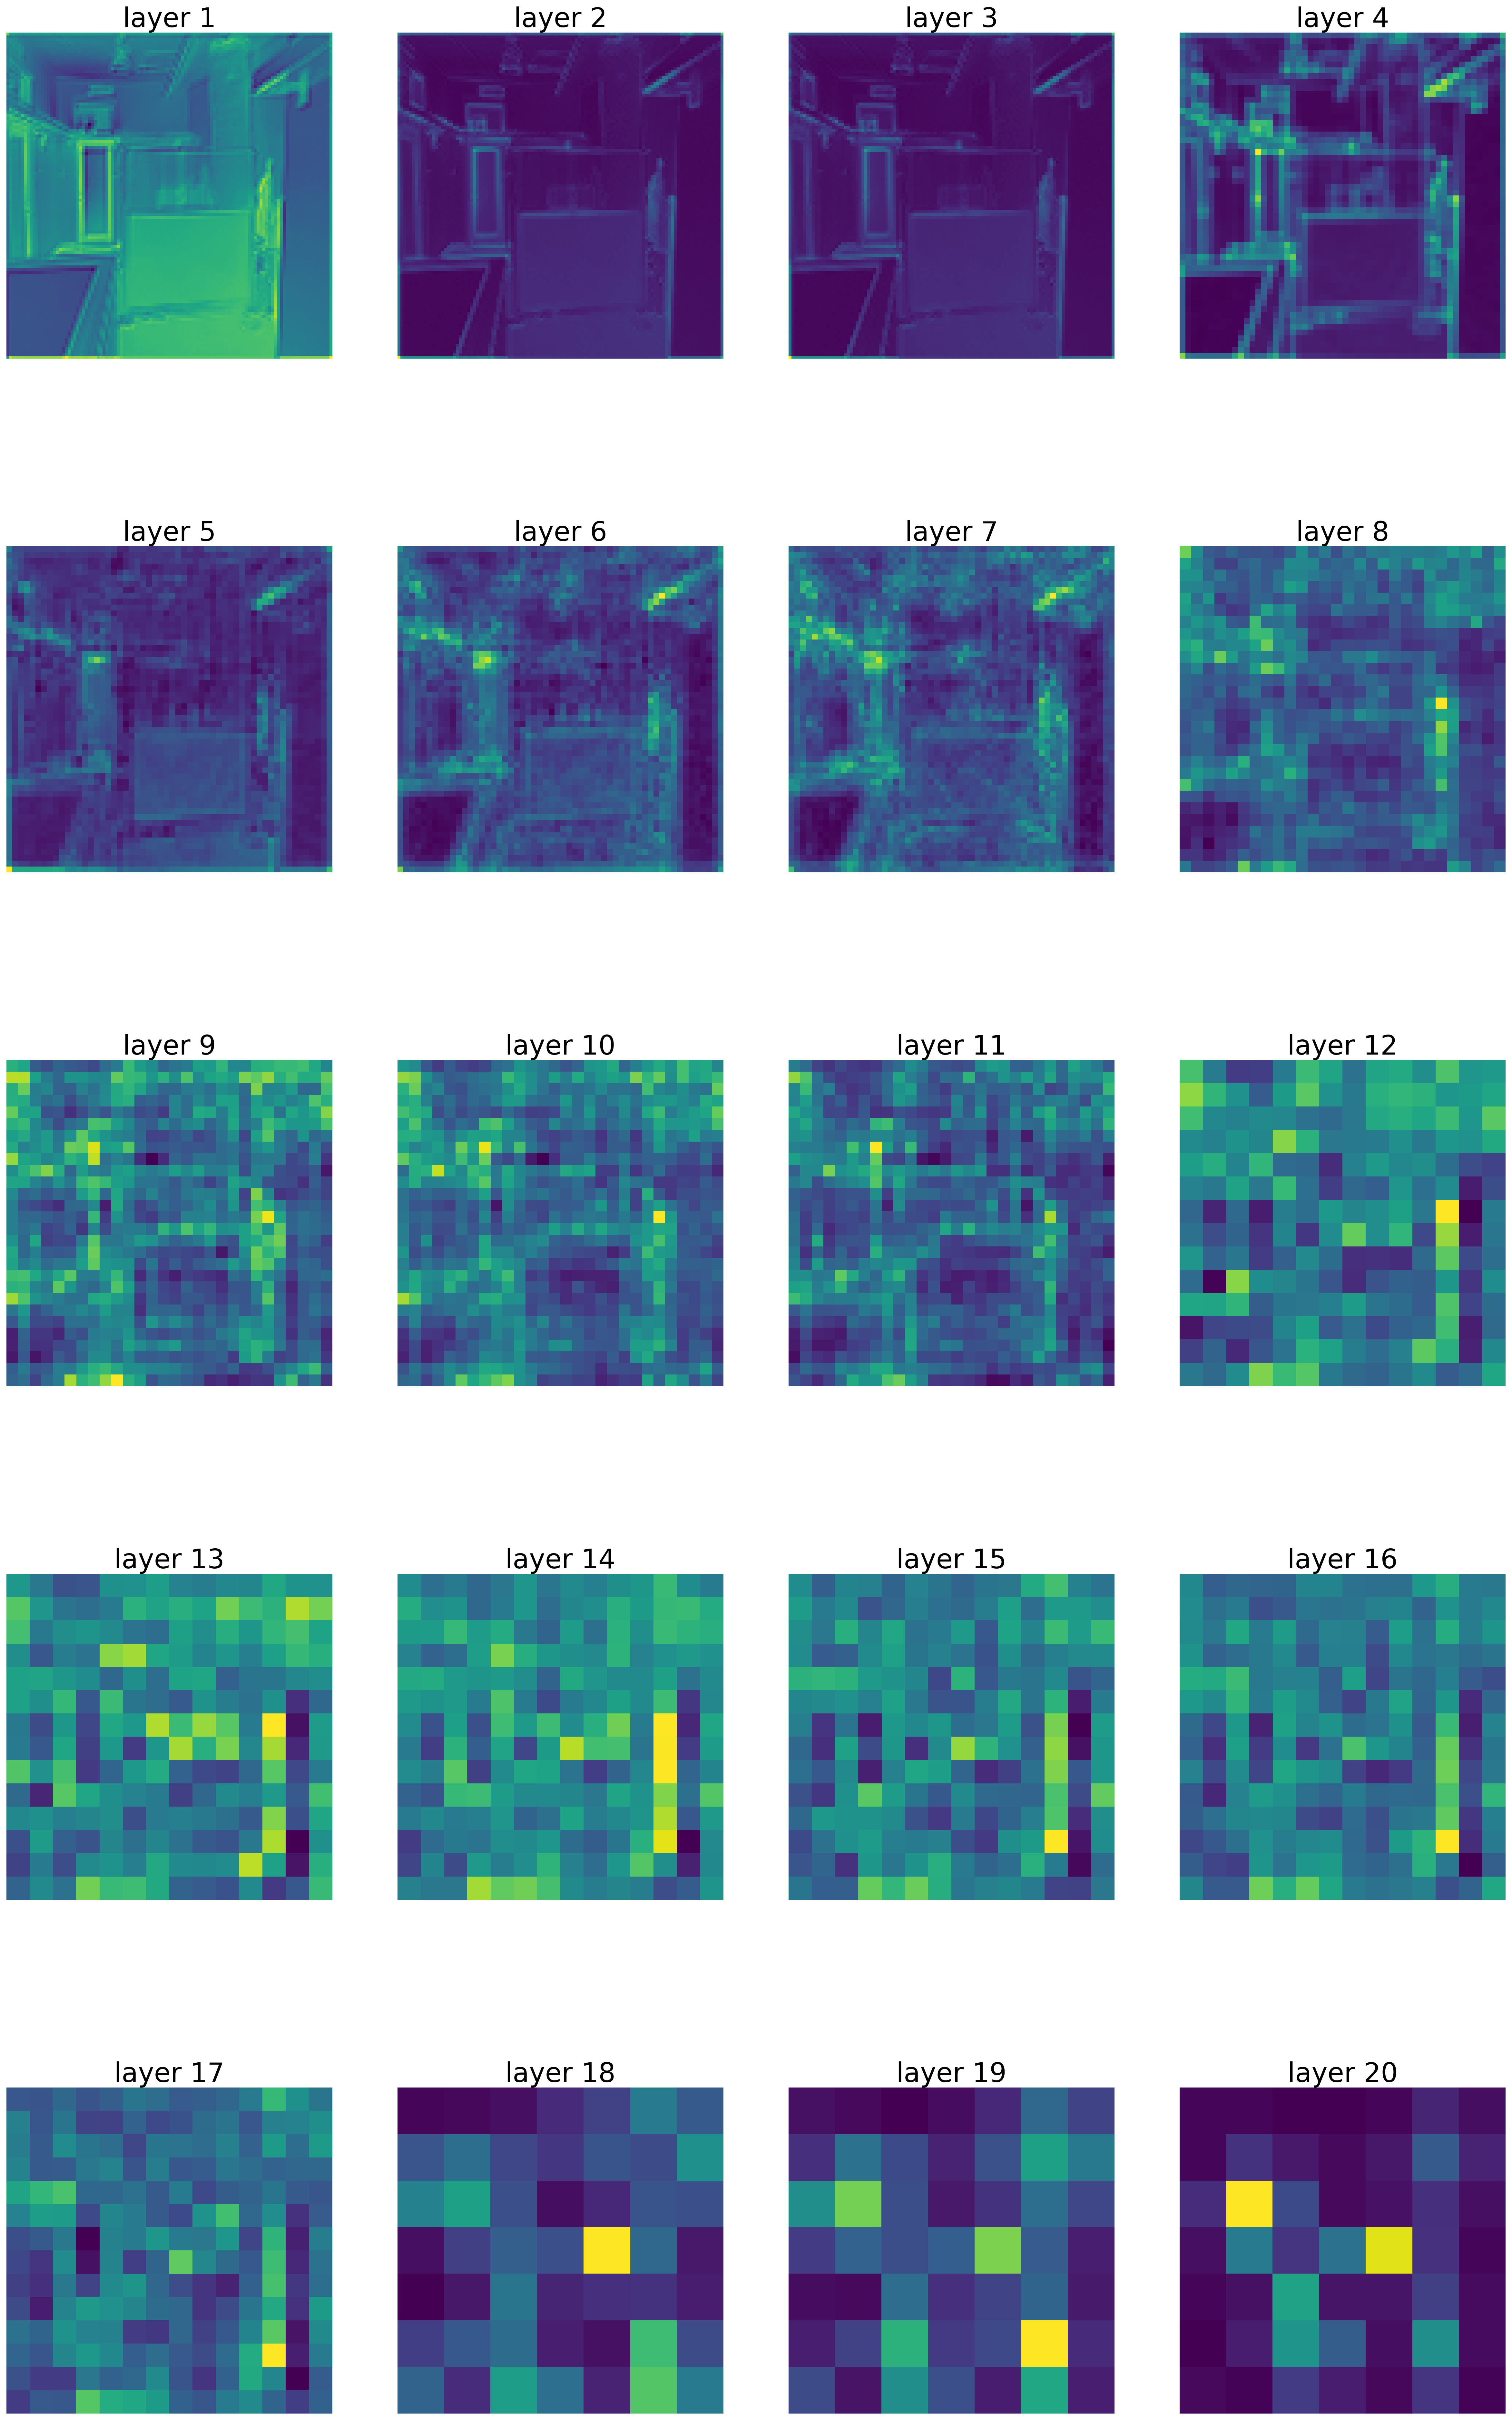

In [118]:
visualize_resnet_features(model, image)

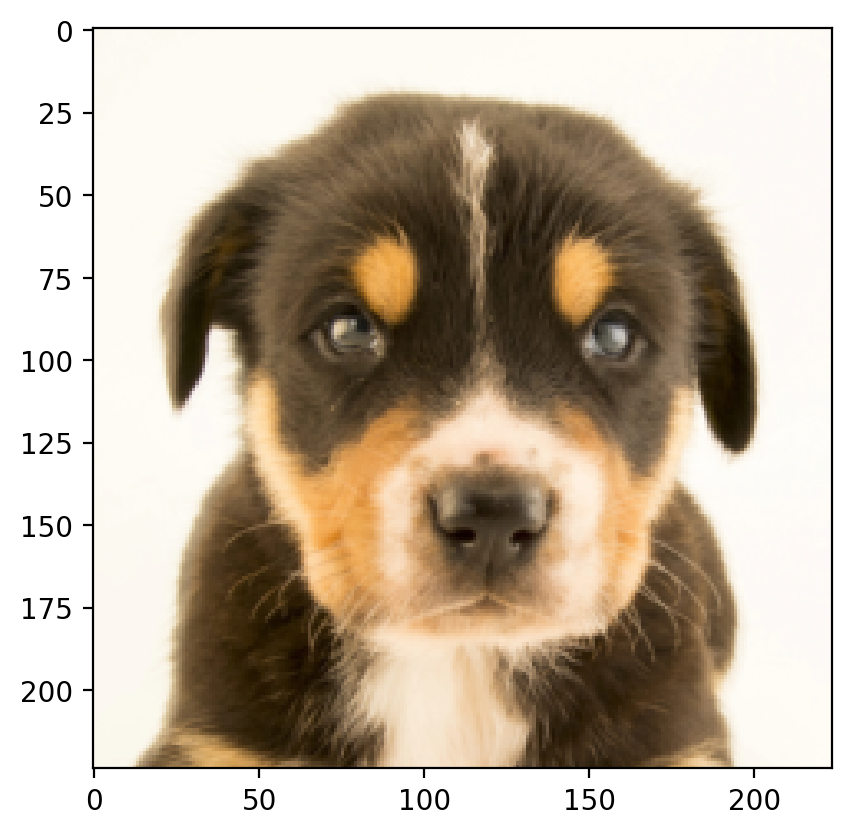

In [131]:
image = transform(PIL.Image.open("dog.jpeg"))
plt.imshow(image.permute(1, 2, 0))

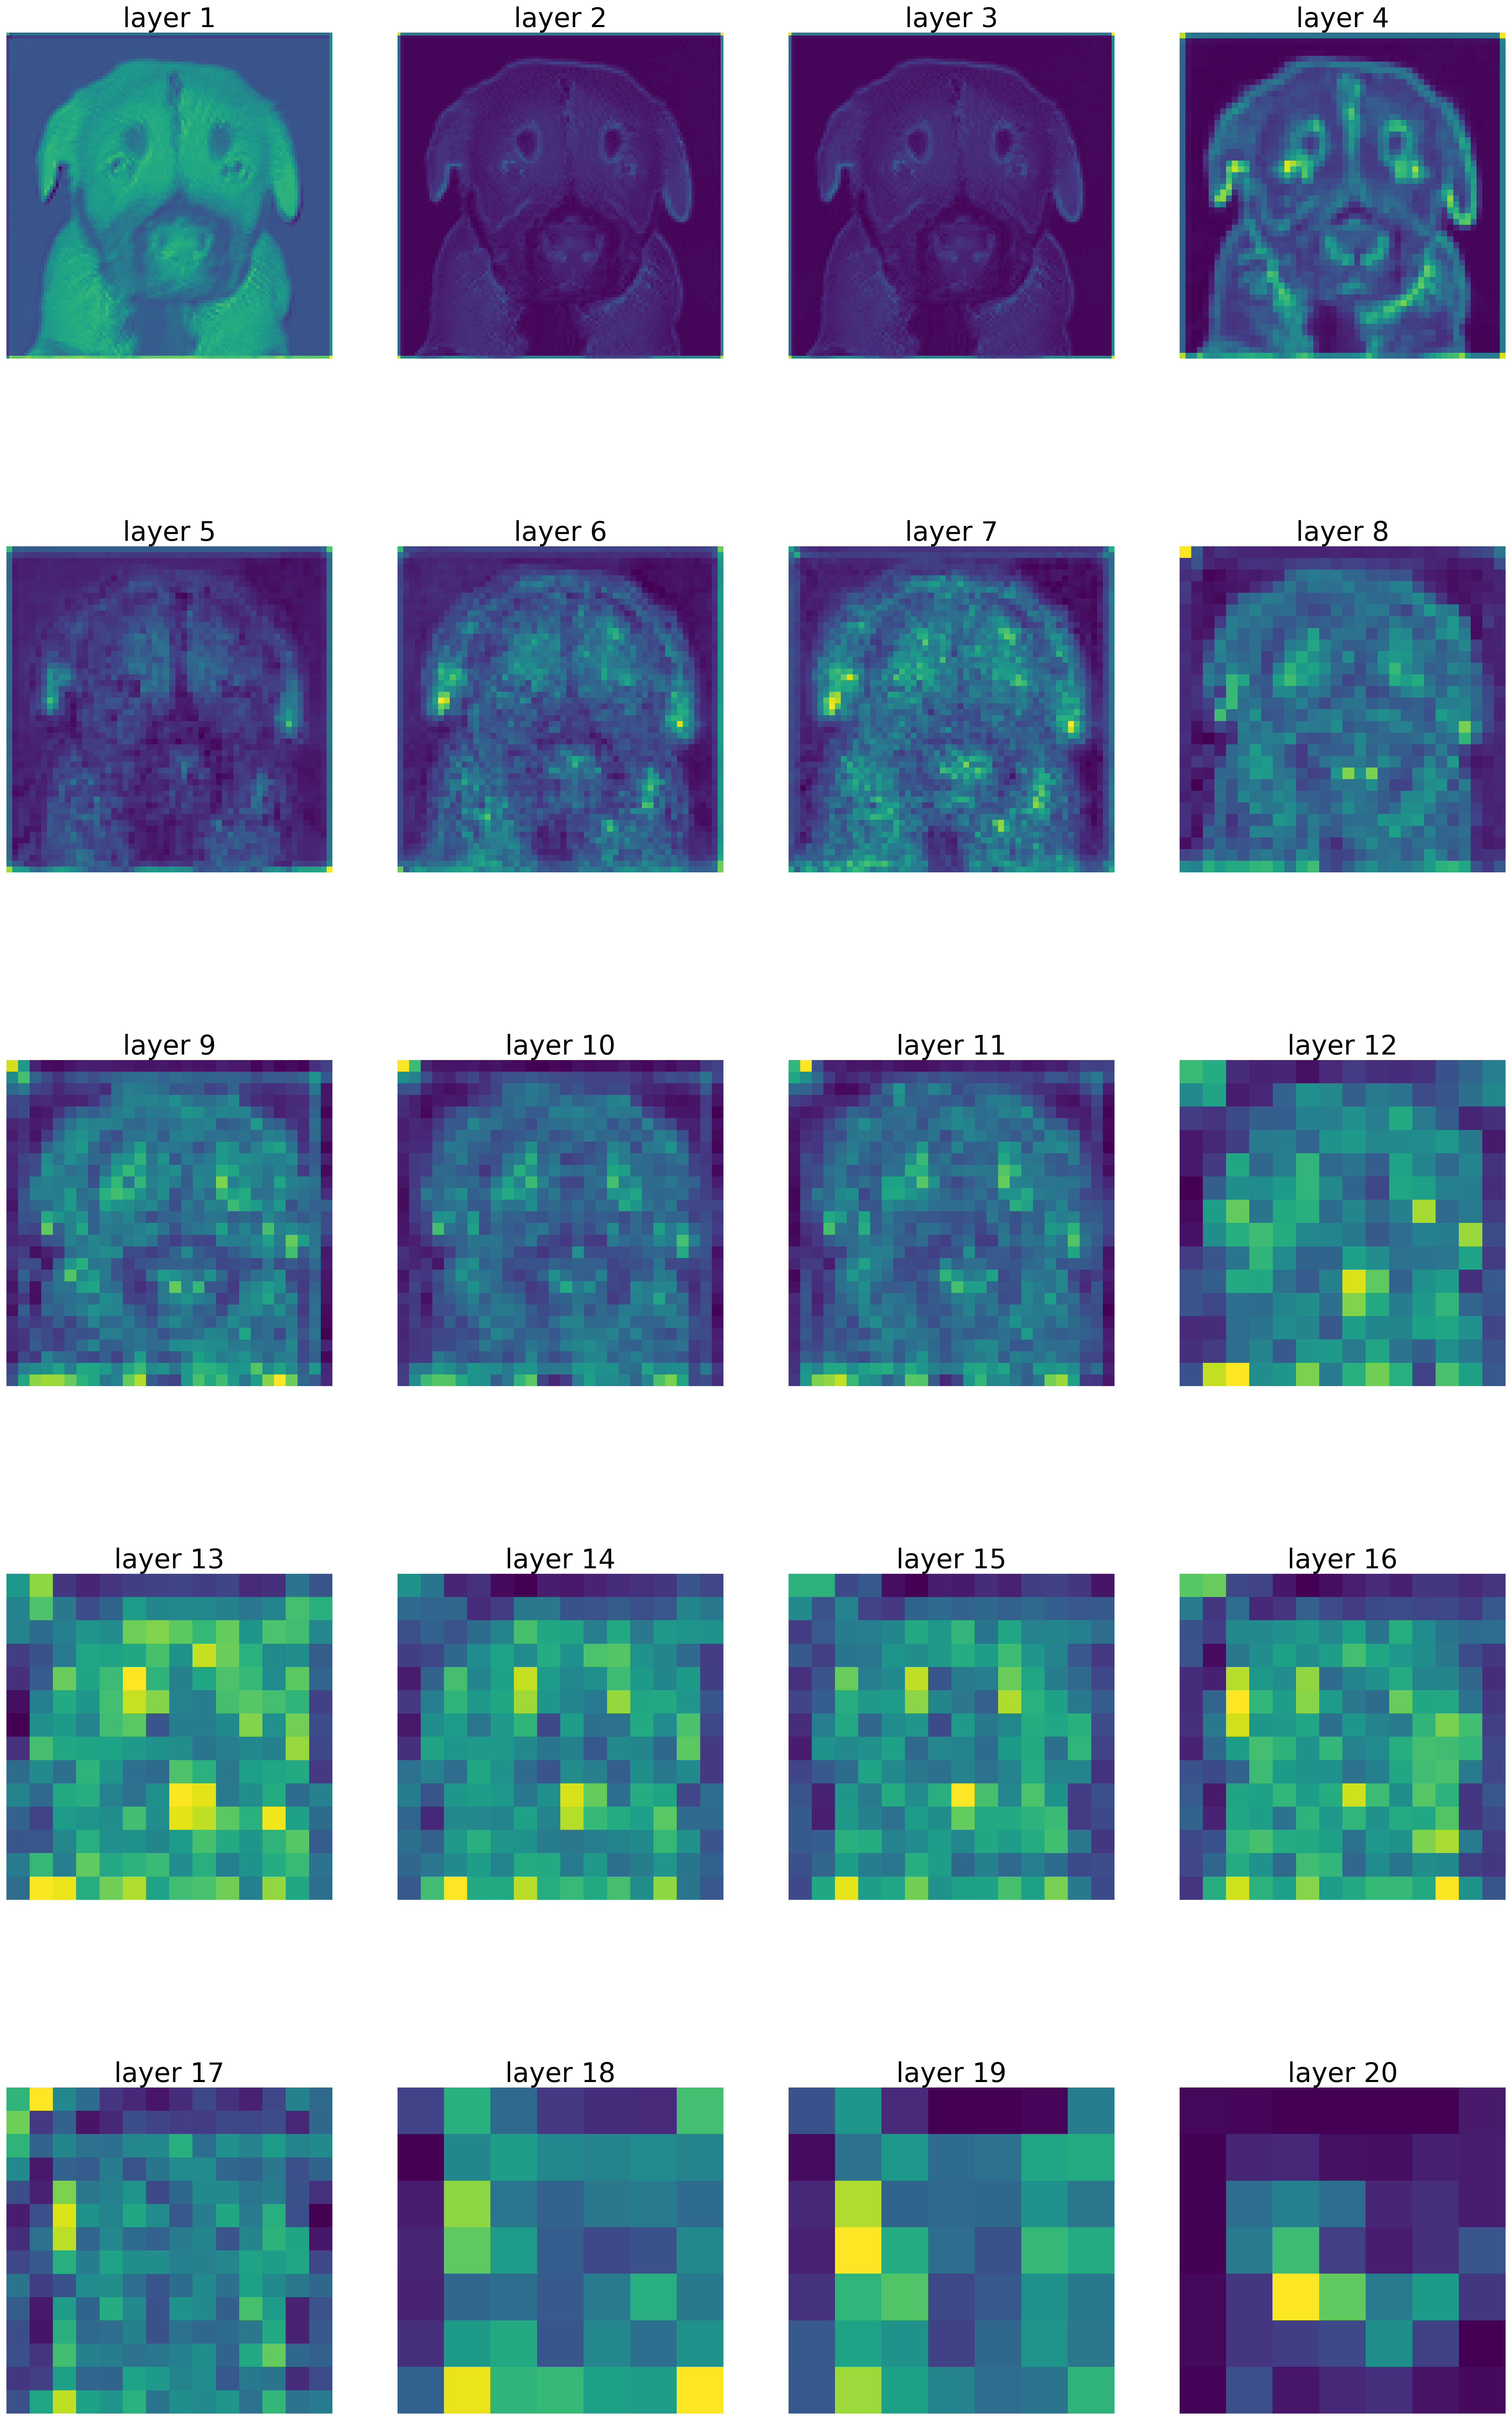

In [132]:
class Original():
    def __init__(self):
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        layers = list(resnet.children())[:-1]
        self.resnet_layers = nn.Sequential(*layers)
        
visualize_resnet_features(Original(), image)